In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import InceptionResNetV2

from keras.layers import Activation, Dropout, Flatten, Dense
from keras import regularizers, Sequential
from keras.layers.normalization import BatchNormalization
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
batch_size = 64

In [ ]:
# rescale normalizes the data for the images.
# Data is split into train and validation sets
image_data_gen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True,
                                    validation_split=0.2)

train_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/tb2/TB_Chest_Radiography_Database',
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              subset='training'
                                             )

val_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/tb2/TB_Chest_Radiography_Database',
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              subset='validation'
                                             )

test_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/TestImages for TB',
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              shuffle = False,
                                              class_mode='binary',
                                             )

Found 4264 images belonging to 2 classes.
Found 1066 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
dnn201 = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    input_tensor=None,
    input_shape=(224,224,3),
    weights = 'imagenet'
)

dnn201.trainable= False

global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
predictions = Dense(1, activation='sigmoid')

model = Sequential([
    dnn201,
    global_avg_layer,
    
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    predictions
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

219062272/219055592 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
batch_normalization_203 (Bat (None, 1536)              6144      
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1573888   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_______________________________________________________

In [ ]:
epochs = 10
histort = model.fit(train_it,
                       validation_data=val_it, epochs=epochs )
#model.save('InceptionResNetV2.h')

Epoch 1/10
67/67 [==============================] - 1664s 24s/step - loss: 0.4259 - accuracy: 0.8357 - val_loss: 0.9074 - val_accuracy: 0.6876
Epoch 2/10
67/67 [==============================] - 102s 2s/step - loss: 0.2179 - accuracy: 0.9259 - val_loss: 0.5672 - val_accuracy: 0.8030
Epoch 3/10
67/67 [==============================] - 101s 2s/step - loss: 0.1829 - accuracy: 0.9368 - val_loss: 0.2891 - val_accuracy: 0.8931
Epoch 4/10
67/67 [==============================] - 101s 2s/step - loss: 0.1730 - accuracy: 0.9386 - val_loss: 0.2322 - val_accuracy: 0.9090
Epoch 5/10
67/67 [==============================] - 101s 2s/step - loss: 0.1585 - accuracy: 0.9430 - val_loss: 0.1506 - val_accuracy: 0.9381
Epoch 6/10
67/67 [==============================] - 101s 2s/step - loss: 0.1436 - accuracy: 0.9450 - val_loss: 0.1181 - val_accuracy: 0.9550
Epoch 7/10
67/67 [==============================] - 100s 1s/step - loss: 0.1385 - accuracy: 0.9457 - val_loss: 0.1919 - val_accuracy: 0.9315
Epoch 8/10


In [ ]:

model.save("InceptionResNetV2.h5", save_format="h5")

In [ ]:
#results = model.evaluate(val_it)

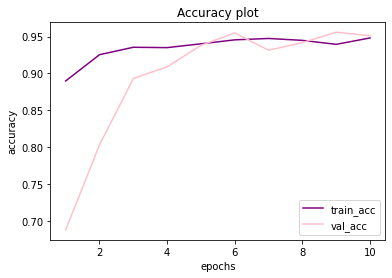

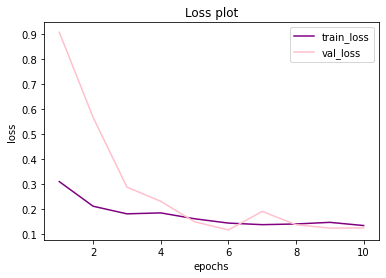

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
epochs= range(1, len(histort.history["accuracy"])+1)

plt.plot(epochs, histort.history["accuracy"], color="purple")
plt.plot(epochs, histort.history["val_accuracy"], color="pink")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")
plt.legend(["train_acc", "val_acc"])
plt.show()

plt.plot(epochs, histort.history["loss"], color="purple")
plt.plot(epochs, histort.history["val_loss"], color="pink")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [ ]:
results = model.evaluate(val_it)

17/17 [==============================] - 19s 1s/step - loss: 0.1311 - accuracy: 0.9484


In [ ]:

prediction= model.predict(val_it, verbose=2)
prediction= (prediction > 0.5)
prediction

17/17 - 21s


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [ ]:
val_labels=val_it.classes
val_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

0.5365853658536586
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       700
           1       0.31      0.30      0.30       366

    accuracy                           0.54      1066
   macro avg       0.48      0.48      0.48      1066
weighted avg       0.53      0.54      0.53      1066



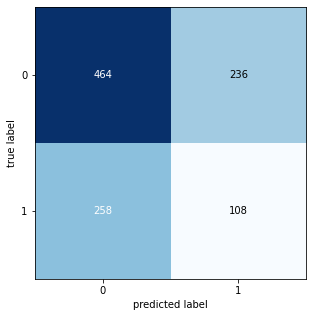

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(val_it.classes, prediction)
plot_confusion_matrix(cm, figsize=(5,5))
print(accuracy_score(val_it.classes, prediction))
print(classification_report(val_it.classes, prediction))

In [ ]:
results = model.evaluate(test_it)


4/4 [==============================] - 43s 14s/step - loss: 0.0535 - accuracy: 0.9800


In [ ]:
prediction1 = model.predict(test_it)
prediction1 = (prediction1 > 0.5)
prediction1

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

0.985
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.98       100

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200



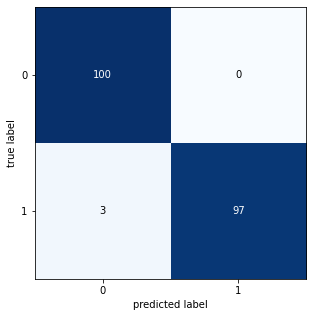

In [ ]:
cm1 = confusion_matrix(test_it.classes, prediction1)
plot_confusion_matrix(cm1, figsize=(5,5))
print(accuracy_score(test_it.classes, prediction1))
print(classification_report(test_it.classes, prediction1))

In [ ]:
from PIL import Image

image = Image.open('/content/drive/MyDrive/tb2/TB_Chest_Radiography_Database/Normal/Normal-1000.png')

In [ ]:
image.show()

In [ ]:
print(image.format)

PNG


In [ ]:
pip install wand

     |████████████████████████████████| 143kB 23.8MB/s 


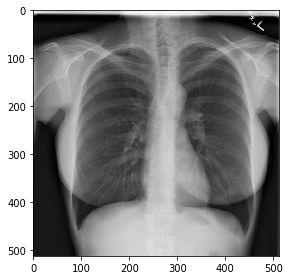

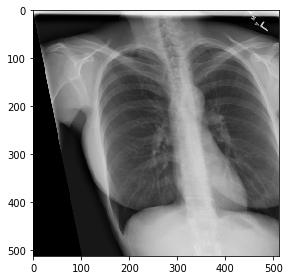

In [ ]:
from skimage import io
from skimage import transform as tf

# Load the image as a matrix
image = io.imread("/content/drive/MyDrive/tb2/TB_Chest_Radiography_Database/Normal/Normal-1000.png")

io.imshow(image)
io.show()
# Create Afine transform
afine_tf = tf.AffineTransform(shear=0.2)

# Apply transform to image data
modified = tf.warp(image, inverse_map=afine_tf)

# Display the result
io.imshow(modified)
io.show()

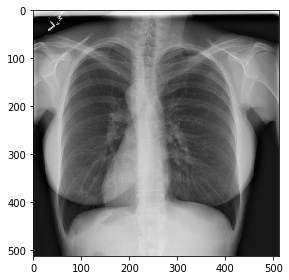

In [ ]:
 from google.colab.patches import cv2_imshow
 import cv2
image= cv2.imread('/content/drive/MyDrive/tb2/TB_Chest_Radiography_Database/Normal/Normal-1000.png')
 flippedimage= cv2.flip(image, 1)
 io.imshow(flippedimage)
io.show()

In [ ]:
from scipy import ndimage, misc
import matplotlib.pyplot as plt



SyntaxError: ignored